# Within-sample validation against withheld validation block

Leave out a block of data and predict the withheld data using the remaining data. Models include cokriging, kriging,
and trend-only prediction.

In [1]:
import sys

sys.path.insert(0, "../../source")


In [2]:
from copy import deepcopy
import pickle
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm

import plot
import prediction
import validation


In [3]:
from logging import ERROR
import dask
from dask.distributed import Client

dask.config.set({"logging.distributed": "error"})

# NOTE: update depending on which node is used
N_WORKERS = 84
client = Client(n_workers=N_WORKERS, silence_logs=ERROR)


/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45737 instead
  warnings.warn(


In [4]:
# number of nearest observations used in point predictions
NUM_LOCAL_VALUES = 150

# data selection
YEAR = 2021
MONTH = 7
# XCO2 months ahead of SIF
OFFSET = 1

year_month_str = f"{YEAR}0{MONTH}" if MONTH < 10 else f"{YEAR}{MONTH}"


In [5]:
month_xco2 = MONTH + OFFSET
date_sif = f"{YEAR}-{MONTH}-01"
date_xco2 = f"{YEAR}-{month_xco2}-01"

with xr.open_dataset(
    "../../data/intermediate/OCO2_005deg_months2021_north_america_with_basis.nc4"
) as ds:
    basis_vars = [x for x in list(ds.keys()) if x.startswith("B")]
    ds_sif = ds[["sif", "sif_var"] + basis_vars].sel(time=f"{YEAR}-{MONTH}").squeeze()


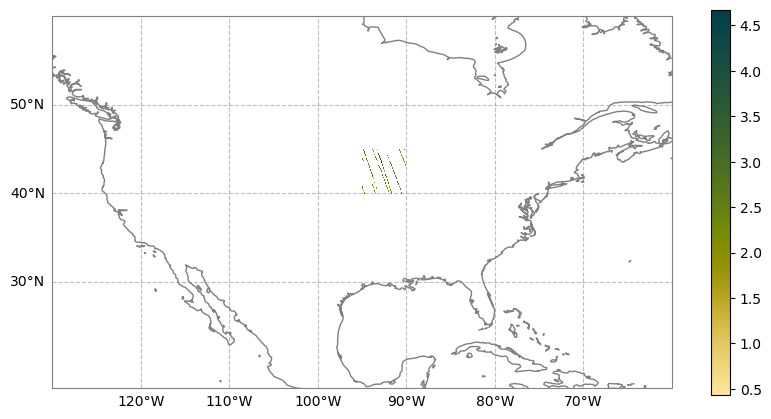

In [6]:
BLOCK_NAME = "b1"
block_conditions = (
    (ds_sif["lon"] > -95) & (ds_sif["lon"] < -90) & (ds_sif["lat"] > 40) & (ds_sif["lat"] < 45)
)
ds_test = ds_sif.where(block_conditions)

plot.plot_da(ds_test["sif"])


In [7]:
df_test = (
    ds_test.to_dataframe()
    .dropna(subset="sif")
    .reset_index()[["lat", "lon", "sif", "sif_var"] + basis_vars]
    .rename(columns={"sif": "data", "sif_var": "me_variance"})
)
df_me_variance = df_test.loc[:, ["lat", "lon", "me_variance"]]
df_test = df_test.drop(columns="me_variance")
ds_covariates = (
    df_test.set_index(["lat", "lon"]).to_xarray().drop_vars(["data", "B1", "B10", "B20"])
)
df_test = df_test.loc[:, ["lat", "lon", "data"]]
pcoords = df_test.loc[:, ["lat", "lon"]]
df_test.to_csv(f"../../data/intermediate/validation/{year_month_str}/df_test_{BLOCK_NAME}.csv")
df_test


,lat,lon,data
0,40.025,-94.725,2.288461
1,40.025,-93.475,1.241077
2,40.025,-91.675,2.409287
3,40.025,-91.625,2.269722
4,40.025,-90.525,3.168826
...,...,...,...
752,44.975,-92.375,1.972841
753,44.975,-90.825,2.770036
754,44.975,-90.775,2.311076
755,44.975,-90.225,2.414655


In [8]:
ds_covariates


<xarray.Dataset>
Dimensions:  (lat: 100, lon: 99)
Coordinates:
  * lat      (lat) float64 40.02 40.07 40.12 40.17 ... 44.82 44.87 44.92 44.97
  * lon      (lon) float64 -94.97 -94.92 -94.87 -94.82 ... -90.12 -90.07 -90.02
Data variables: (12/57)
    B2       (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B3       (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B4       (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B5       (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B6       (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B7       (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    ...       ...
    B55      (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B56      (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B57      (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B58      (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B59      (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan
    B60      (lat, lon) float64 nan nan nan nan nan 0.0 ... 0.0 0.0 nan nan nan

## Cokriging

In [9]:
# Load multifield and model objects
with open(f"../../data/intermediate/models/{year_month_str}/fields.pickle", "rb") as f:
    mf = pickle.load(f)

with open(f"../../data/intermediate/models/{year_month_str}/bivariate_model.pickle", "rb") as f:
    bivariate_matern = pickle.load(f)


In [10]:
# Make validation predictions
cokrige = prediction.Predictor(bivariate_matern, mf)
dict_cokrige = cokrige.validation_prediction(
    0,
    pcoords,
    df_me_variance,
    ds_covariates,
    num_local_values=NUM_LOCAL_VALUES,
)
ds_cokrige = dict_cokrige["ds"]
ds_cokrige


INFO | root:_compute_prediction_covariance_matrix:485 | Running predictive covariance
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 400 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 0 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 300 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 200 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 700 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 600 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 500 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 100 ...


<xarray.Dataset>
Dimensions:               (lat: 100, lon: 99)
Coordinates:
  * lat                   (lat) float64 40.02 40.07 40.12 ... 44.87 44.92 44.97
  * lon                   (lon) float64 -94.97 -94.92 -94.87 ... -90.07 -90.02
    time                  <U9 '2021-7-01'
Data variables: (12/66)
    residual_predictions  (lat, lon) float64 nan nan nan nan ... nan nan nan
    residual_uncertainty  (lat, lon) float64 nan nan nan nan ... nan nan nan
    validity_flag         (lat, lon) float64 nan nan nan nan ... 1.0 nan nan nan
    B2                    (lat, lon) float64 nan nan nan nan ... 0.0 nan nan nan
    B3                    (lat, lon) float64 nan nan nan nan ... 0.0 nan nan nan
    B4                    (lat, lon) float64 nan nan nan nan ... 0.0 nan nan nan
    ...                    ...
    trend_surface         (lat, lon) float64 nan nan nan nan ... nan nan nan
    me_variance           (lat, lon) float32 nan nan nan nan ... nan nan nan
    predictions           (lat, lon) float64 nan nan nan nan ... nan nan nan
    scaled_residuals      (lat, lon) float64 nan nan nan nan ... nan nan nan
    trend_surface_rmspe   (lat, lon) float32 0.247 0.247 0.247 ... 0.247 0.247
    rmspe                 (lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    timedeltas:        [0, 1]
    num_local_values:  150

In [11]:
# Save multivariate predictive distribution
pd.DataFrame(dict_cokrige["predictive_mean"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/mean_cokriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)

pd.DataFrame(dict_cokrige["predictive_covariance_matrix"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/covariance_cokriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


In [12]:
# Prepare validation results
df_cokrige = (
    ds_cokrige.to_dataframe().reset_index()[["lat", "lon", "predictions", "rmspe"]].dropna()
)

df_test_cokrige = validation.prepare_validation_results(
    df_cokrige,
    df_test,
    method="cokriging",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_cokrige = sm.ProbPlot(df_test_cokrige["ratio"].values)
df_quantiles_cokrige = pd.DataFrame(
    dict(
        sample=quantiles_cokrige.sample_quantiles,
        theoretical=quantiles_cokrige.theoretical_quantiles,
        Method="Cokriging",
    )
)


## Kriging

In [13]:
client.close()


In [14]:
client = Client(n_workers=N_WORKERS, silence_logs=ERROR)


/home/jj829/miniconda3/envs/geostat/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42815 instead
  warnings.warn(


In [15]:
# Isolate SIF field only
mf_univariate = deepcopy(mf)
mf_univariate.fields = np.array([mf_univariate.fields[0]])
mf_univariate.n_procs = 1

# Load univariate model
with open(
    f"../../data/intermediate/models/{year_month_str}/univariate_model.pickle", "rb"
) as f:
    univariate_matern = pickle.load(f)


In [16]:
# Make validation predictions
krige = prediction.Predictor(univariate_matern, mf_univariate)
dict_krige = krige.validation_prediction(
    0,
    pcoords,
    df_me_variance,
    ds_covariates,
    num_local_values=NUM_LOCAL_VALUES,
)
ds_krige = dict_krige["ds"]
ds_krige


INFO | root:_compute_prediction_covariance_matrix:485 | Running predictive covariance
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 400 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 0 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 300 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 200 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 700 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 600 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 100 ...
INFO | root:_compute_predictive_covariance_element:549 | Status: a = 500 ...


<xarray.Dataset>
Dimensions:               (lat: 100, lon: 99)
Coordinates:
  * lat                   (lat) float64 40.02 40.07 40.12 ... 44.87 44.92 44.97
  * lon                   (lon) float64 -94.97 -94.92 -94.87 ... -90.07 -90.02
    time                  <U9 '2021-7-01'
Data variables: (12/66)
    residual_predictions  (lat, lon) float64 nan nan nan nan ... nan nan nan
    residual_uncertainty  (lat, lon) float64 nan nan nan nan ... nan nan nan
    validity_flag         (lat, lon) float64 nan nan nan nan ... 1.0 nan nan nan
    B2                    (lat, lon) float64 nan nan nan nan ... 0.0 nan nan nan
    B3                    (lat, lon) float64 nan nan nan nan ... 0.0 nan nan nan
    B4                    (lat, lon) float64 nan nan nan nan ... 0.0 nan nan nan
    ...                    ...
    trend_surface         (lat, lon) float64 nan nan nan nan ... nan nan nan
    me_variance           (lat, lon) float32 nan nan nan nan ... nan nan nan
    predictions           (lat, lon) float64 nan nan nan nan ... nan nan nan
    scaled_residuals      (lat, lon) float64 nan nan nan nan ... nan nan nan
    trend_surface_rmspe   (lat, lon) float32 0.247 0.247 0.247 ... 0.247 0.247
    rmspe                 (lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    timedeltas:        [0, 1]
    num_local_values:  150

In [17]:
# Save multivariate predictive distribution
pd.DataFrame(dict_krige["predictive_mean"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/mean_kriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)

pd.DataFrame(dict_krige["predictive_covariance_matrix"]).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/covariance_kriging_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


In [18]:
# Prepare validation results
df_krige = (
    ds_krige.to_dataframe().reset_index()[["lat", "lon", "predictions", "rmspe"]].dropna()
)

df_test_krige = validation.prepare_validation_results(
    df_krige,
    df_test,
    method="kriging",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_krige = sm.ProbPlot(df_test_krige["ratio"].values)
df_quantiles_krige = pd.DataFrame(
    dict(
        sample=quantiles_krige.sample_quantiles,
        theoretical=quantiles_krige.theoretical_quantiles,
        Method="Kriging",
    )
)


## Trend-only

In [19]:
# Prepare validation results
df_trend = (
    ds_krige.to_dataframe()
    .reset_index()[["lat", "lon", "trend_surface", "trend_surface_rmspe"]]
    .dropna()
    .rename(columns={"trend_surface": "predictions", "trend_surface_rmspe": "rmspe"})
)

df_test_trend = validation.prepare_validation_results(
    df_trend,
    df_test,
    method="Trend surface",
    month=year_month_str,
    region=BLOCK_NAME,
)

# Compute QQ-plot quantiles
quantiles_trend = sm.ProbPlot(df_test_trend["ratio"].values)
df_quantiles_trend = pd.DataFrame(
    dict(
        sample=quantiles_trend.sample_quantiles,
        theoretical=quantiles_trend.theoretical_quantiles,
        Method="Trend surface",
    )
)


In [20]:
# Save multivariate predictive distribution
df_test_trend["predictions"].to_csv(
    f"../../data/intermediate/validation/{year_month_str}/mean_trend_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)
pd.DataFrame(np.diag(df_test_trend["rmspe"].values ** 2)).to_csv(
    f"../../data/intermediate/validation/{year_month_str}/covariance_trend_{BLOCK_NAME}.csv",
    header=None,
    index=None,
)


## Collect results

In [21]:
df_validation_results = pd.concat(
    [df_test_trend, df_test_krige, df_test_cokrige], axis=0
).reset_index(drop=True)
df_validation_results.to_csv(
    f"../../data/intermediate/validation/{year_month_str}/validation_results_{BLOCK_NAME}.csv"
)
df_validation_results


,Method,Month,Region,lat,lon,data,predictions,rmspe,difference,ratio,INT,DSS
0,Trend surface,202107,b1,40.025,-94.725,2.288461,2.504674,0.591556,0.216213,0.365499,2.322574,-0.916409
1,Trend surface,202107,b1,40.025,-93.475,1.241077,2.612256,0.549991,1.371180,2.493094,13.818910,5.019810
2,Trend surface,202107,b1,40.025,-91.675,2.409287,2.567297,0.559071,0.158009,0.282628,2.195033,-1.083078
3,Trend surface,202107,b1,40.025,-91.625,2.269722,2.565487,0.567656,0.295765,0.521028,2.228740,-0.861008
4,Trend surface,202107,b1,40.025,-90.525,3.168826,2.523535,0.575585,-0.645291,-1.121104,2.259872,0.152140
...,...,...,...,...,...,...,...,...,...,...,...,...
2266,Cokriging,202107,b1,44.975,-92.375,1.972841,1.961864,0.504210,-0.010977,-0.021770,1.979637,-1.369050
2267,Cokriging,202107,b1,44.975,-90.825,2.770036,2.179664,0.545849,-0.590372,-1.081565,2.143122,-0.041041
2268,Cokriging,202107,b1,44.975,-90.775,2.311076,2.182078,0.557774,-0.128998,-0.231273,2.189940,-1.114116
2269,Cokriging,202107,b1,44.975,-90.225,2.414655,2.183551,0.544822,-0.231103,-0.424181,2.139087,-1.034663


In [22]:
df_quantiles = pd.concat(
    [df_quantiles_trend, df_quantiles_krige, df_quantiles_cokrige], axis=0
).reset_index(drop=True)
df_quantiles.to_csv(
    f"../../data/intermediate/validation/{year_month_str}/validation_ratio_quantiles_{BLOCK_NAME}.csv"
)

df_quantiles


,sample,theoretical,Method
0,-3.762768,-3.006986,Trend surface
1,-3.088172,-2.789617,Trend surface
2,-2.498926,-2.655650,Trend surface
3,-2.479085,-2.557126,Trend surface
4,-2.479054,-2.478527,Trend surface
...,...,...,...
2266,2.621445,2.478527,Cokriging
2267,2.676061,2.557126,Cokriging
2268,2.978627,2.655650,Cokriging
2269,2.995082,2.789617,Cokriging


In [23]:
client.close()
